## Tile outlier detection
In many of the images, there are sections where the marker values are over-exposed or erroneous. 
Marker-by-marker try to detect faulty tiles with a Grubbs test

Algorithm--

1. Get metadata
    - can be found in the original raw data (with all regions)
         a. In the XML, look for the 'RegionWidth_tiles' and 'RegionHeight_tiles' tag
         b. wait...there's also 'TileWidth_px', 'TileHeight_px', and 'TileOverlap'
     - I think we want (a) because the image we actually use is already stiched and registered
2. Get tile details
    - !! Open the split raw image used for CellSeg input...Or should I use the 'for_QuPath' inputs?? !!
    - get appropriate tile dimensions based on XML meta (will not perfectly fit because the image cut from the raw)
    - need to get the tissue boundaries (if appropriate)
        - for 1 good 'region', sum across the marker axis
            (a) for each tile in the 'flattened' image, flag if >50% zero pixels  
            (b) DAPI signal is < 50%
    - for each good 'region', for each marker, for each tile:
        - ignore tile if outside tissue
        - calculate mean signal
        - combine results as vector across all good 'regions'
3. Evaluate tiles
    - for each bad 'region', for each marker, for each tile:
        - (the tested tile should be included in the sample population)
        - calculate t-statistic
            - scipy.stats.t.ppf()
        - run Grubb's outlier test (two-sided? yes)
    - remove failed tiles
        - in raw CellSeg input image, force marker outlier tiles to 0
    - correct outlier annotations
        - should all annotations in an outlier tile be removed? Or just tiles with an important outlier marker?
            - leaning towards the former

In [1]:
import tifffile as tff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import xml.etree.ElementTree as ET
import os
import anndata as ad
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import tqdm

In [16]:
# dictionary of raw images
raw_img_dir = '/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/Data'
raw_dat = {
    'K1':os.path.join(raw_img_dir, '20220312_Kikushi_LN_K1.qptiff'),
    'K2':os.path.join(raw_img_dir, '20220316_Kikushi_LN_K2.qptiff'),
    'MCD4':os.path.join(raw_img_dir, '20220619_Castleman_Disease_LN_FFPE_M4.qptiff'),
    'HVCD2':os.path.join(raw_img_dir, '20220617_Castleman_Disease_LN_FFPE_HVCD_2.qptiff'),
    'HVCD1':os.path.join(raw_img_dir, '20220515_Castleman_LN_HVCD1.qptiff'),
    'K3':os.path.join(raw_img_dir, '20220713 Kikuchi LN_K3.qptiff'),
    'MCD1':os.path.join(raw_img_dir, '20220509_Castleman_LN_MCD_1.qptiff'),
    'MCD3':os.path.join(raw_img_dir, '20220513_Castleman_LN_MCD3.qptiff'),
    'R1':os.path.join(raw_img_dir, '20220311_Reactive_LN_R1.qptiff')
}

In [4]:
datadir = '/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/' # or, should I use the cellseg input??
sample_list = os.listdir(datadir)
# sample_list = list(set(sample_list).difference(set(bad_regions)))
short_name = list(map(lambda x: x.split('_')[0], sample_list))
loc_dict = {i:[] for i in set(short_name)}
for i,j in zip(short_name, sample_list):
    loc_dict[i].append(os.path.join(datadir, j))

In [5]:
bad_regions = ['MCD1_reg1','MCD1_reg3','MCD3_reg1','R2','HVCD2_reg1','HVCD2_reg3','MCD4_reg1','K3_reg1','K3_reg3','K3_reg4']


In [6]:
def extract_tiling_dims(path):
    ome_xml = tff.tiffcomment(path)
    tif_meta = ET.XML(ome_xml)
    tile_w = []
    tile_h = []
    # How will R2 handle this with 1 region? Maybe skip it?
    for i in tif_meta.findall("./ScanProfile/*/Regions/Region"):
        tile_w.append(int(i.find('RegionWidth_tiles').text))
        tile_h.append(int(i.find('RegionHeight_tiles').text))
    region_grid = tuple(zip(tile_w, tile_h))
    return region_grid

In [7]:
def tile_generator(data, tileshape):
    for y in range(0, data.shape[1], tileshape[0]):
        for x in range(0, data.shape[2], tileshape[1]):
            tile = data[:, y: y+tileshape[0], x: x+tileshape[1]]
            if tile.shape[1:] != tileshape:
                continue
            yield tile

In [8]:
def load_region(p,r):
    # load image
    if not os.path.isfile(os.path.join(p, 'full_input_codex.qptiff')):
        os.rename(os.path.join(p, 'input_codex.qptiff'), os.path.join(p, 'full_input_codex.qptiff'))
    tifim = tff.TiffFile(os.path.join(p, 'full_input_codex.qptiff'))
    grid_shape = r[int(p[-1])-1]
    tileshape = int(tifim.series[0].shape[1]/grid_shape[0]), int(tifim.series[0].shape[2]/grid_shape[1]) # get the dimensions
    dat = tifim.series[0].asarray()
    # create tiles
    tiles = tile_generator(dat, tileshape)
    return tiles


In [9]:
def test_tile(mdat):
    # Finding the G test value
    marker_mu = mdat.mean()
    marker_sd = mdat.std()
    n = len(mdat)
    G = abs(mdat[-1] - marker_mu) / marker_sd
    # Calculating the G statistic
    t_stat = stats.t.ppf(1-0.01, n-2)
    G_crit = ((n - 1)/np.sqrt(n)) * np.sqrt(t_stat**2 / (n - 2 + t_stat**2))
    if G > G_crit:
        return True
    else:
        return False
    

In [10]:
def identify_fail(g):
    tile_score_sums = np.apply_along_axis(np.sum, 0, g)
    fail_tiles = tile_score_sums > 8 # arbitrary threshold for # of failed markers
    if np.any(tile_score_sums < 0): 
        boundary_tiles = np.where(tile_score_sums < 0)[0]
        for b in boundary_tiles:
            if b > 0 and b < len(fail_tiles)-1:
                if fail_tiles[b-1] or fail_tiles[b+1]:
                    fail_tiles[b] = True
            elif b==0:
                if fail_tiles[b+1]:
                    fail_tiles[b] = True
            elif b==len(fail_tiles)-1:
                if fail_tiles[b-1]:
                    fail_tiles[b] = True
    return np.where(fail_tiles)[0]

In [11]:
def clean_image(img, grid, fails):
    tileshape = int(img.shape[1]/grid[0]), int(img.shape[2]/grid[1])
    # tileshape = np.array(img.shape[1:])/np.array(grid)
    for t in fails:
        xx = (t % int(grid[1]) ) * tileshape[1]
        yy = int(t/int(grid[1])) * tileshape[0]
        img[:, yy:yy + tileshape[0], xx:xx+tileshape[1]] = 0
    return img

In [12]:
def write_image_to_file(img, p):
    # rename the old file
    short_name = p.split('/')[-1]
    outpath = os.path.join("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data", short_name)
    outname = os.path.join(outpath, 'input_codex.qptiff')
    if not os.path.isfile(os.path.join(outpath, 'full_input_codex.qptiff')):
        os.rename(os.path.join(outpath, 'input_codex.qptiff'), os.path.join(outpath, 'full_input_codex.qptiff'))

    xml = f"""<?xml version="1.0" encoding="UTF-8"?>
    <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
        <Image ID="Image:0" Name="{outname}">
            <Pixels BigEndian="false"
                    DimensionOrder="XYCZT"
                    ID="Pixels:0"
                    Interleaved="false"
                    SizeC="{img.shape[0]}"
                    SizeT="1"
                    SizeX="{img.shape[2]}"
                    SizeY="{img.shape[1]}"
                    SizeZ="1"
                    PhysicalSizeX="1.0"
                    PhysicalSizeY="1.0"
                    Type="float">
                <TiffData />
                </Pixels>
        </Image>
    </OME>
    """
    tff.imwrite(
        outname,
        data=img,
        photometric='minisblack',
        description=xml,
        # tile=(256, 256),
        # resolution=(25400, 25400, "inch"),
        # compress=9,
        # metadata={'Channel': {'MarkerName': list(channel_names)}}
    )

In [13]:
def filter_annotations(img, grid, fails, p):
    short_name = p.split('/')[-1]
    outpath = '/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis'
    if not os.path.isfile(os.path.join(outpath, short_name, 'gated_dat_full.h5ad')):
        os.rename(os.path.join(outpath, short_name, 'gated_dat.h5ad'), os.path.join(outpath, short_name, 'gated_dat_full.h5ad'))
    adata = ad.read_h5ad(os.path.join(outpath, short_name, 'gated_dat_full.h5ad'))
    
    # scanning the annotations for bad tiles
    tileshape = int(img.shape[1]/grid[0]), int(img.shape[2]/grid[1])
    for t in tqdm.tqdm(fails):
        xx = (t % int(grid[1]) ) * tileshape[1]
        yy = int(t/int(grid[1])) * tileshape[0]
        pregion = Polygon([(xx,yy), (xx,yy+tileshape[0]), (xx+tileshape[1],yy+tileshape[0]), (xx+tileshape[1], yy)])
        keep = [not pregion.contains(Point(x,y)) for x,y in zip(adata.obs['Absolute.X'], adata.obs['Absolute.Y'])]
        adata = adata[keep,:]
    adata.write(os.path.join(outpath, short_name, 'gated_dat.h5ad'))
        

In [289]:
sample = 'MCD4'
rawpath = raw_dat[sample]
region_grid = extract_tiling_dims(rawpath)
# building the baseline stuff...
tile_stats = []
print('getting baseline values...')
for p in loc_dict[sample]:
    # print(p)
    if p.split('/')[-1] not in bad_regions:
        tiles = load_region(p, region_grid)
        for t in tiles:
            # determine if tile is boundary
            DAPI_signal = np.sum(t[0,...] == 0)
            pixel_area = t.shape[1] * t.shape[2]
            # tile_stats.append(DAPI_signal/pixel_area)
            if DAPI_signal > 0.2 * pixel_area:
                continue
            # collect mean marker signal
            mean_signal = np.apply_over_axes(np.mean, t, [1,2])
            # mean_signal = np.apply_over_axes(np.sum, t, [1,2])
            tile_stats.append(mean_signal.flatten())
good_region_stats = np.column_stack(tile_stats)

getting baseline values...


In [304]:
# p = '/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/MCD4_reg2'
for p in loc_dict[sample]:
    grubbs_stats = []
    # if p.split('/')[-1] in bad_regions:
    tiles = load_region(p, region_grid)
    for t in tiles:
        # determine if tile is boundary
        DAPI_signal = np.sum(t[0,...] == 0)
        pixel_area = t.shape[1] * t.shape[2]
        # grubbs_stats.append(DAPI_signal/pixel_area)
        if DAPI_signal > 0.1 * pixel_area:
            grubbs_stats.append(np.array([-1] * good_region_stats.shape[0])) # to mark boundaries
            continue
        # collect mean marker signal
        mean_signal = np.apply_over_axes(np.mean, t, [1,2]).flatten()
        # mean_signal = np.apply_over_axes(np.sum, t, [1,2]).flatten()
        test_dat = np.hstack((good_region_stats, mean_signal.reshape(44,-1)))
        Grubbs_res = np.apply_along_axis(test_tile, 1, test_dat)
        grubbs_stats.append(Grubbs_res)
    grubbs_stats = np.column_stack(grubbs_stats)    
    if np.sum(grubbs_stats[0,:] == -1) > 0.75 * np.prod(region_grid[0]):
            print("failed DAPI boundary test")
            grubbs_stats = []
            tiles = load_region(p, region_grid)
            for t in tiles:
                # collect mean marker signal
                mean_signal = np.apply_over_axes(np.mean, t, [1,2]).flatten()
                test_dat = np.hstack((good_region_stats, mean_signal.reshape(44,-1)))
                Grubbs_res = np.apply_along_axis(test_tile, 1, test_dat)
                grubbs_stats.append(Grubbs_res)
            grubbs_stats = np.column_stack(grubbs_stats)

    # cleaning the input image
    print('scrubbing data...')
    tifim = tff.TiffFile(os.path.join('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data', p.split('/')[-1], 'full_input_codex.qptiff'))
    img = tifim.asarray()
    # crop out pixels that would be at boundaries, should be very few
    bound_tiles = region_grid[int(p[-1])-1]
    new_width = img.shape[1] - (img.shape[1] % bound_tiles[0])
    new_height = img.shape[2] - (img.shape[2] % bound_tiles[1])
    img = img[:, 0:new_width, 0:new_height]
    # identify failed tiles
    fail_tiles = identify_fail(grubbs_stats)
    print(str(len(fail_tiles)) + ' tiles failed')
    if len(fail_tiles) == 0:
        continue
    elif len(fail_tiles) < 0.9 * (bound_tiles[0] * bound_tiles[1]):
        img = clean_image(img, bound_tiles, fail_tiles)
        write_image_to_file(img, p)
        filter_annotations(img, bound_tiles, fail_tiles, p)
    else:
        print('failed region')
        with open(os.path.join('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis', p.split('/')[-1], 'all_tiles_failed.token'),'w') as f:
            pass

failed DAPI boundary test
scrubbing data...
0 tiles failed


0it [00:00, ?it/s]


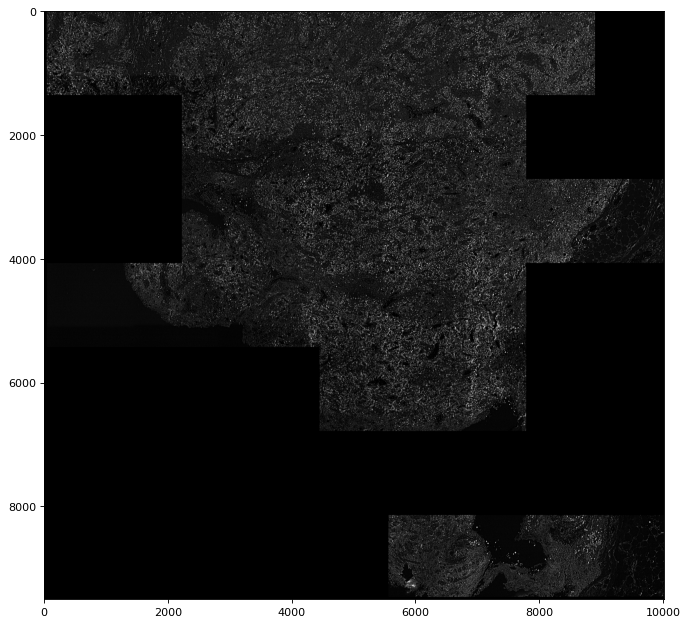

In [172]:
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img[1,...], cmap='gray')

In [233]:
for sample, rawpath in tqdm.tqdm(raw_dat.items()):
    print(sample)
    region_grid = extract_tiling_dims(rawpath)
    # building the baseline stuff...
    tile_stats = []
    print('getting baseline values...')
    for p in loc_dict[sample]:
        # print(p)
        if p.split('/')[-1] not in bad_regions:
            tiles = load_region(p, region_grid)
            for t in tiles:
                # determine if tile is boundary
                DAPI_signal = np.sum(t[0,...] == 0)
                pixel_area = t.shape[1] * t.shape[2]
                if DAPI_signal > 0.1 * pixel_area:
                    continue
                # collect mean marker signal
                mean_signal = np.apply_over_axes(np.mean, t, [1,2])
                tile_stats.append(mean_signal.flatten())
    good_region_stats = np.column_stack(tile_stats)

    # now testing the 'bad' regions
    print('working on bad regions...')
    for p in loc_dict[sample]:
        grubbs_stats = []
        # if p.split('/')[-1] in bad_regions: # running grubbs on all regions
        tiles = load_region(p, region_grid)
        for t in tiles:
            # determine if tile is boundary
            DAPI_signal = np.sum(t[0,...] == 0)
            pixel_area = t.shape[1] * t.shape[2]
            if DAPI_signal > 0.1 * pixel_area:
                grubbs_stats.append(np.array([-1] * good_region_stats.shape[0])) # to mark boundaries
                continue
            # collect mean marker signal
            mean_signal = np.apply_over_axes(np.mean, t, [1,2]).flatten()
            test_dat = np.hstack((good_region_stats, mean_signal.reshape(44,-1)))
            Grubbs_res = np.apply_along_axis(test_tile, 1, test_dat)
            grubbs_stats.append(Grubbs_res)
        grubbs_stats = np.column_stack(grubbs_stats)
        # redo the tests if it thinks most the image is boundaries/empty space (due to poor DAPI signal)
        if np.sum(grubbs_stats[0,:] == -1) > 0.75 * np.prod(region_grid[0]):
            print("failed DAPI boundary test")
            grubbs_stats = []
            tiles = load_region(p, region_grid)
            for t in tiles:
                # collect mean marker signal
                mean_signal = np.apply_over_axes(np.mean, t, [1,2]).flatten()
                test_dat = np.hstack((good_region_stats, mean_signal.reshape(44,-1)))
                Grubbs_res = np.apply_along_axis(test_tile, 1, test_dat)
                grubbs_stats.append(Grubbs_res)
            grubbs_stats = np.column_stack(grubbs_stats)

        # cleaning the input image
        print('scrubbing data...')
        tifim = tff.TiffFile(os.path.join('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data', p.split('/')[-1], 'full_input_codex.qptiff'))
        img = tifim.asarray()
        # crop out pixels that would be at boundaries, should be very few
        bound_tiles = region_grid[int(p[-1])-1]
        new_width = img.shape[1] - (img.shape[1] % bound_tiles[0])
        new_height = img.shape[2] - (img.shape[2] % bound_tiles[1])
        img = img[:, 0:new_width, 0:new_height]
        # identify failed tiles
        fail_tiles = identify_fail(grubbs_stats)
        print(str(len(fail_tiles)) + ' tiles failed')
        if len(fail_tiles) < 0.9 * (bound_tiles[0] * bound_tiles[1]):
            img = clean_image(img, bound_tiles, fail_tiles)
            write_image_to_file(img, p)
            filter_annotations(img, bound_tiles, fail_tiles, p)
        else:
            print("FAILED REGION")
            with open(os.path.join('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis', p.split('/')[-1], 'all_tiles_failed.token'),'w') as f:
                pass

  0%|          | 0/9 [00:00<?, ?it/s]

K1
getting baseline values...
working on bad regions...
scrubbing data...
0 tiles failed
failed DAPI boundary test
scrubbing data...
0 tiles failed
failed DAPI boundary test
scrubbing data...
1 tiles failed



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


failed DAPI boundary test
scrubbing data...


 11%|█         | 1/9 [02:43<21:45, 163.14s/it]

0 tiles failed
K2
getting baseline values...
working on bad regions...
scrubbing data...
0 tiles failed
scrubbing data...
0 tiles failed
scrubbing data...
3 tiles failed



100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


scrubbing data...
4 tiles failed



 22%|██▏       | 2/9 [05:40<20:00, 171.43s/it]

MCD4
getting baseline values...
working on bad regions...
failed DAPI boundary test
scrubbing data...
81 tiles failed
FAILED REGION
failed DAPI boundary test
scrubbing data...
81 tiles failed
FAILED REGION
failed DAPI boundary test
scrubbing data...
48 tiles failed



100%|██████████| 48/48 [02:25<00:00,  3.04s/it]


failed DAPI boundary test
scrubbing data...


 33%|███▎      | 3/9 [11:02<24:01, 240.23s/it]

81 tiles failed
FAILED REGION
HVCD2
getting baseline values...
working on bad regions...
scrubbing data...
30 tiles failed



100%|██████████| 30/30 [01:22<00:00,  2.75s/it]


scrubbing data...
4 tiles failed



100%|██████████| 4/4 [00:14<00:00,  3.54s/it]


scrubbing data...
0 tiles failed
failed DAPI boundary test
scrubbing data...
0 tiles failed
scrubbing data...


 44%|████▍     | 4/9 [14:02<18:02, 216.52s/it]

0 tiles failed
HVCD1
getting baseline values...
working on bad regions...
scrubbing data...
0 tiles failed
scrubbing data...
0 tiles failed
scrubbing data...
0 tiles failed
scrubbing data...


 56%|█████▌    | 5/9 [15:32<11:23, 170.87s/it]

0 tiles failed
K3
getting baseline values...
working on bad regions...
scrubbing data...
9 tiles failed



100%|██████████| 9/9 [00:24<00:00,  2.74s/it]


failed DAPI boundary test
scrubbing data...
4 tiles failed



100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


scrubbing data...
0 tiles failed
failed DAPI boundary test
scrubbing data...
7 tiles failed



100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


failed DAPI boundary test
scrubbing data...


 67%|██████▋   | 6/9 [17:58<08:07, 162.34s/it]

0 tiles failed
MCD1
getting baseline values...
working on bad regions...
scrubbing data...
37 tiles failed



100%|██████████| 37/37 [02:02<00:00,  3.32s/it]


scrubbing data...
5 tiles failed



100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


scrubbing data...
1 tiles failed



100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


scrubbing data...


 78%|███████▊  | 7/9 [22:33<06:38, 199.19s/it]

0 tiles failed
MCD3
getting baseline values...
working on bad regions...
scrubbing data...
0 tiles failed
failed DAPI boundary test
scrubbing data...
48 tiles failed



100%|██████████| 48/48 [00:55<00:00,  1.16s/it]


scrubbing data...
6 tiles failed



 89%|████████▉ | 8/9 [25:05<03:04, 184.30s/it]

R1
getting baseline values...
working on bad regions...
scrubbing data...
0 tiles failed
scrubbing data...
4 tiles failed



100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


scrubbing data...


100%|██████████| 9/9 [26:15<00:00, 175.04s/it]

0 tiles failed


In [26]:
tifim = tff.TiffFile("../forQuPath/Data/K3_reg4/full_input_codex.qptiff")

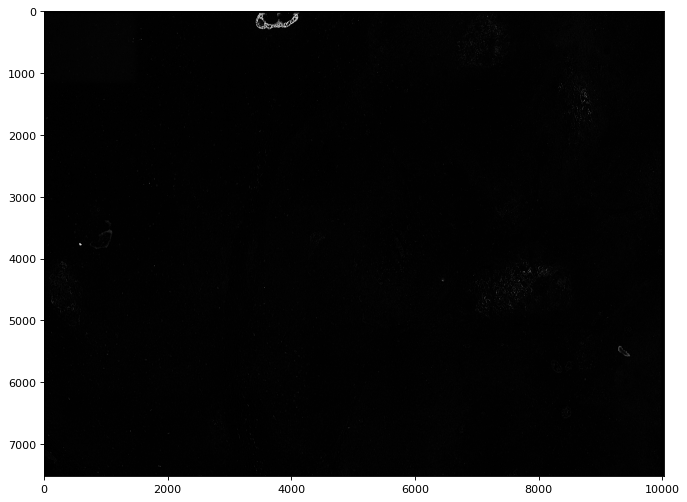

In [41]:
plt.figure(figsize=(10, 10), dpi=80)
test = tifim.series[0].pages[19].asarray()
plt.imshow(test, cmap='gray')

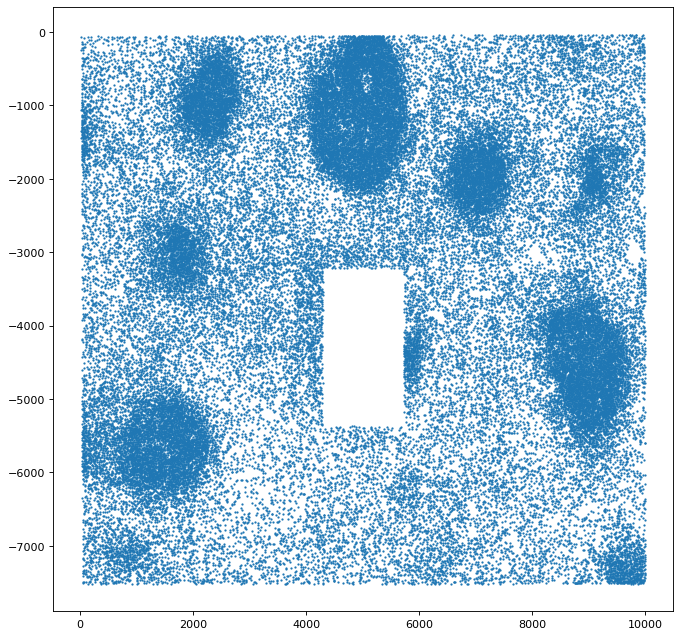

In [58]:
cells = adata.obs.loc[adata.obs['new_pheno']=='B_Cell', ['Absolute.X','Absolute.Y']]
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(cells['Absolute.X'], -1*cells['Absolute.Y'], s=1)